#Instal Libraries

In [3]:
!pip install cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 39.3 MB/s eta 0:00:00


#Load Data

ne_110m_admin_0_countries.zip

Temporal change % every 5 years
vegUrban1990.csv
vegUrban1995.csv
vegUrban2000.csv
vegUrban2005.csv
vegUrban2010.csv
vegUrban2015.csv
vegUrban2020.csv
treeUrban1990.csv
treeUrban1995.csv
treeUrban2000.csv
treeUrban2005.csv
treeUrban2010.csv
treeUrban2015.csv
treeUrban2020.csv

Temporal analysis every five years with fixed extents from 1990 and 2020
vegUrban_1990_2020_constBuiltUp2020_100m.csv
vegUrban_1990_2020_constBuiltUp1992_100m.csv
treeUrban_1990_2020_constBuiltUp2020_100m.csv
treeUrban_1990_2020_constBuiltUp1992_100m.csv


In [35]:
!unzip /content/ne_110m_admin_0_countries.zip

Archive:  /content/ne_110m_admin_0_countries.zip
replace ne_110m_admin_0_countries.README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# % change every 5 years

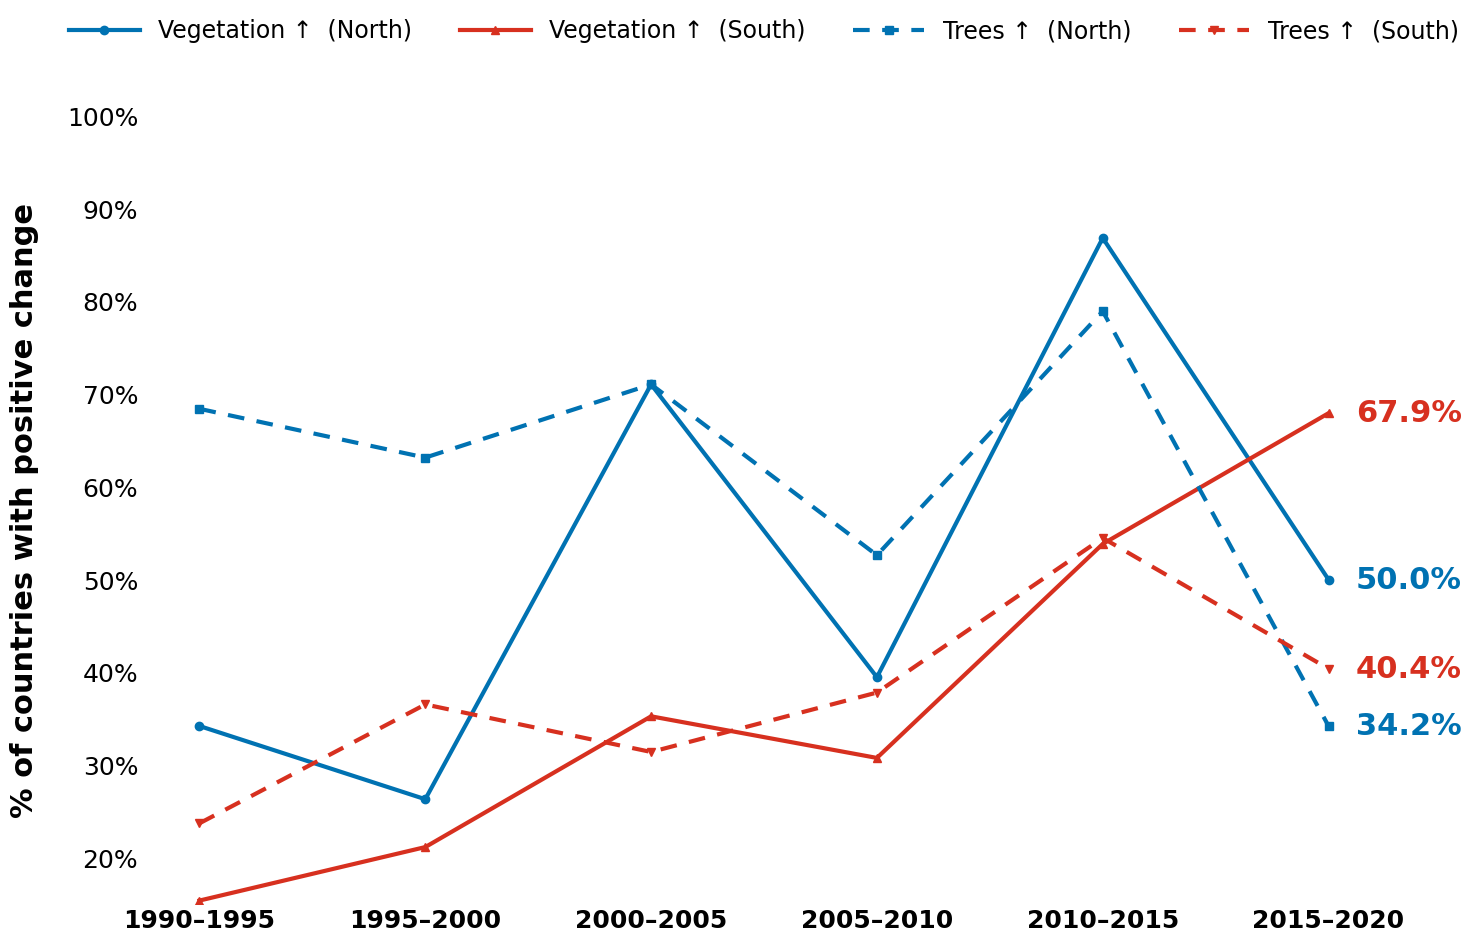

In [34]:
from __future__ import annotations
import warnings
from typing import Optional, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ──────────────────────────────────────────────────────────────────
# 0.  GLOBAL NORTH BY ISO3  (as provided)
# ──────────────────────────────────────────────────────────────────
GLOBAL_NORTH_ISO3 = {
    "ARE","AUS","AUT","BEL","CAN","CHE","CYP","CZE","DEU","DNK","ESP","EST","FIN","FRA",
    "GBR","GNQ","GRC","HRV","HUN","IRL","ISL","ISR","ITA","JPN","KWT","LUX","NCL","NLD",
    "NOR","NZL","OMN","POL","PRI","PRT","QAT","SAU","SVK","SVN","SWE","TTO","TWN","USA"
}

# ──────────────────────────────────────────────────────────────────
# 1.  HELPERS
# ──────────────────────────────────────────────────────────────────
ISO_CANDIDATES = (
    "shapeISO", "shapeISO_1990", "shapeISO_2020",
    "ISO3", "iso3", "iso_3", "countryISO3", "shapeISO3", "shape_iso3"
)

def _std_iso(s: pd.Series) -> pd.Series:
    """Uppercase + strip whitespace; drop empties to NaN."""
    return s.astype(str).str.strip().str.upper().replace({"": np.nan})

def detect_iso_column(csv_path: str) -> Optional[str]:
    """Read header only and find a plausible ISO3 column."""
    try:
        hdr = pd.read_csv(csv_path, nrows=0)
    except Exception as e:
        warnings.warn(f"Could not read header of {csv_path}: {e}")
        return None
    cols = set(hdr.columns)
    for cand in ISO_CANDIDATES:
        if cand in cols:
            return cand
    # Heuristic: any column containing 'iso' and '3'
    for c in cols:
        lc = c.lower()
        if "iso" in lc and "3" in lc:
            return c
    return None

def read_minimal(csv_path: str, value_col: str, iso_col: str) -> Optional[pd.DataFrame]:
    """Read only (iso_col, value_col) from csv_path; return standardized frame."""
    try:
        df = pd.read_csv(csv_path, usecols=[iso_col, value_col])
    except ValueError:
        # If usecols fails (e.g., missing value_col), try full read then subset.
        try:
            df = pd.read_csv(csv_path)
            missing = [c for c in (iso_col, value_col) if c not in df.columns]
            if missing:
                warnings.warn(f"{csv_path}: missing required columns: {missing}")
                return None
            df = df[[iso_col, value_col]]
        except Exception as e:
            warnings.warn(f"{csv_path}: read error → {e}")
            return None
    except Exception as e:
        warnings.warn(f"{csv_path}: read error → {e}")
        return None

    # Standardize ISO and coerce value to numeric
    df[iso_col] = _std_iso(df[iso_col])
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[iso_col, value_col])
    if df.empty:
        warnings.warn(f"{csv_path}: after cleaning, no valid rows.")
        return None
    return df

def group_by_iso_mean(df: pd.DataFrame, iso_col: str, value_col: str) -> pd.DataFrame:
    """Mean per ISO3 code."""
    g = df.groupby(iso_col, as_index=False)[value_col].mean()
    g.rename(columns={iso_col: "ISO3", value_col: "val"}, inplace=True)
    return g

# ──────────────────────────────────────────────────────────────────
# 2.  SHARE OF COUNTRIES WITH POSITIVE Δ (ISO3-based)
# ──────────────────────────────────────────────────────────────────
def frac_pos(start: str, end: str,
             csv0: str, csv1: str,
             col: str = 'fractionInUrban',
             north: bool = True) -> Optional[float]:
    """
    Returns the fraction (0–1) of countries with Δ>0 for the chosen group.
    Grouping is by ISO3 using GLOBAL_NORTH_ISO3.
    """
    iso0 = detect_iso_column(csv0)
    iso1 = detect_iso_column(csv1)

    if iso0 is None or iso1 is None:
        warnings.warn(f"{start}-{end}: Could not detect ISO3 column "
                      f"({csv0} iso={iso0}, {csv1} iso={iso1}).")
        return None

    d0 = read_minimal(csv0, col, iso0)
    d1 = read_minimal(csv1, col, iso1)
    if d0 is None or d1 is None:
        warnings.warn(f"{start}-{end}: Failed to read required columns.")
        return None

    g0 = group_by_iso_mean(d0, iso0, col)
    g1 = group_by_iso_mean(d1, iso1, col)

    m = g0.merge(g1, on='ISO3', suffixes=(f'_{start}', f'_{end}'))
    if m.empty:
        warnings.warn(f"{start}-{end}: No ISO3 overlap between files.")
        return None

    # Partition by North vs South
    if north:
        m = m[m['ISO3'].isin(GLOBAL_NORTH_ISO3)]
    else:
        m = m[~m['ISO3'].isin(GLOBAL_NORTH_ISO3)]

    if m.empty:
        warnings.warn(f"{start}-{end}: Group selection empty (north={north}).")
        return None

    m['Δ'] = m[f'val_{end}'] - m[f'val_{start}']
    if m['Δ'].notna().sum() == 0:
        warnings.warn(f"{start}-{end}: Δ all NaN for selected group.")
        return None

    return (m['Δ'] > 0).mean()

# ──────────────────────────────────────────────────────────────────
# 3.  PLOT FOUR SERIES IN ONE FIGURE (NO GRID LINES)
# ──────────────────────────────────────────────────────────────────
def plot_all(lbls: List[str],
             vegN: List[Optional[float]],
             vegS: List[Optional[float]],
             treeN: List[Optional[float]],
             treeS: List[Optional[float]]) -> None:
    if all(v is None for v in (vegN + vegS + treeN + treeS)):
        raise RuntimeError("Nothing to plot.")

    x      = np.arange(len(lbls))
    colors = {'North': '#0072B2', 'South': '#d7301f'}
    dash   = (4, 3)
    lw     = 3

    fig, ax = plt.subplots(figsize=(16, 10))

    # Vegetation – solid
    ax.plot(x, vegN, marker='o', linestyle='-', color=colors['North'],
            linewidth=lw, label='Vegetation ↑  (North)')
    ax.plot(x, vegS, marker='^', linestyle='-', color=colors['South'],
            linewidth=lw, label='Vegetation ↑  (South)')

    # Trees – dashed
    ax.plot(x, treeN, marker='s', linestyle='--', dashes=dash,
            color=colors['North'], linewidth=lw, label='Trees ↑  (North)')
    ax.plot(x, treeS, marker='v', linestyle='--', dashes=dash,
            color=colors['South'], linewidth=lw, label='Trees ↑  (South)')

    ax.set_xticks(x)
    ax.set_xticklabels(lbls, fontsize=18, fontweight='bold')
    ax.set_ylim(15, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
    ax.set_ylabel("% of countries with positive change",
                  fontsize=22, fontweight='bold', labelpad=20)

    # ——— No background grid lines (major or minor) ———
    ax.grid(False, which='both', axis='both')

    # Minimal frame
    for s in ax.spines.values():
        s.set_visible(False)
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0, labelsize=18)

    # Right-end value labels
    series_meta = [
        {'series': vegN,  'color': colors['North']},
        {'series': vegS,  'color': colors['South']},
        {'series': treeN, 'color': colors['North']},
        {'series': treeS, 'color': colors['South']},
    ]
    for meta in series_meta:
        series = meta['series']
        if series and (series[-1] is not None):
            ax.text(
                x[-1] + 0.12,
                series[-1],
                f"{series[-1]:.1f}%",
                color=meta['color'],
                fontsize=22,
                fontweight='bold',
                va='center',
                ha='left'
            )

    # Legend (unchanged; easy to bold later if you want)
    ax.legend(
        ncol=4,
        frameon=False,
        fontsize=17,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.15),
        handlelength=3,
        # prop={'weight': 'bold'}
    )

    fig.tight_layout()
    plt.subplots_adjust(right=0.88, top=0.85)
    plt.savefig('/content/Fig5D.pdf',
                bbox_inches='tight', format='pdf', transparent=True)
    plt.show()

# ──────────────────────────────────────────────────────────────────
# 4.  MAIN
# ──────────────────────────────────────────────────────────────────
def main():
    VEG = {y: f"/content/vegUrban{y}.csv"
           for y in ('1990','1995','2000','2005','2010','2015','2020')}
    TREE = {y: f"/content/"
                 f"treeUrban{y}.csv"
            for y in ('1990','1995','2000','2005','2010','2015','2020')}

    intervals = [('1990','1995'), ('1995','2000'), ('2000','2005'),
                 ('2005','2010'), ('2010','2015'), ('2015','2020')]
    labels = [f"{s}–{e}" for s, e in intervals]

    # Compute shares (fractions) for North vs South, veg and trees
    vegN  = [frac_pos(s, e, VEG[s],  VEG[e],  col='fractionInUrban', north=True)
             for s, e in intervals]
    vegS  = [frac_pos(s, e, VEG[s],  VEG[e],  col='fractionInUrban', north=False)
             for s, e in intervals]
    treeN = [frac_pos(s, e, TREE[s], TREE[e], col='fractionInUrban', north=True)
             for s, e in intervals]
    treeS = [frac_pos(s, e, TREE[s], TREE[e], col='fractionInUrban', north=False)
             for s, e in intervals]

    # Convert fractions → percentages (preserve None)
    to_pct = lambda arr: [v * 100 if v is not None else None for v in arr]
    vegN, vegS, treeN, treeS = map(to_pct, (vegN, vegS, treeN, treeS))

    plot_all(labels, vegN, vegS, treeN, treeS)

if __name__ == '__main__':
    try:
        main()
    except Exception as exc:
        import sys, traceback
        traceback.print_exc()
        sys.exit(f"FAILED: {exc}")


#Fixed extents temporal change

Figure saved → /content/Fig5B.pdf


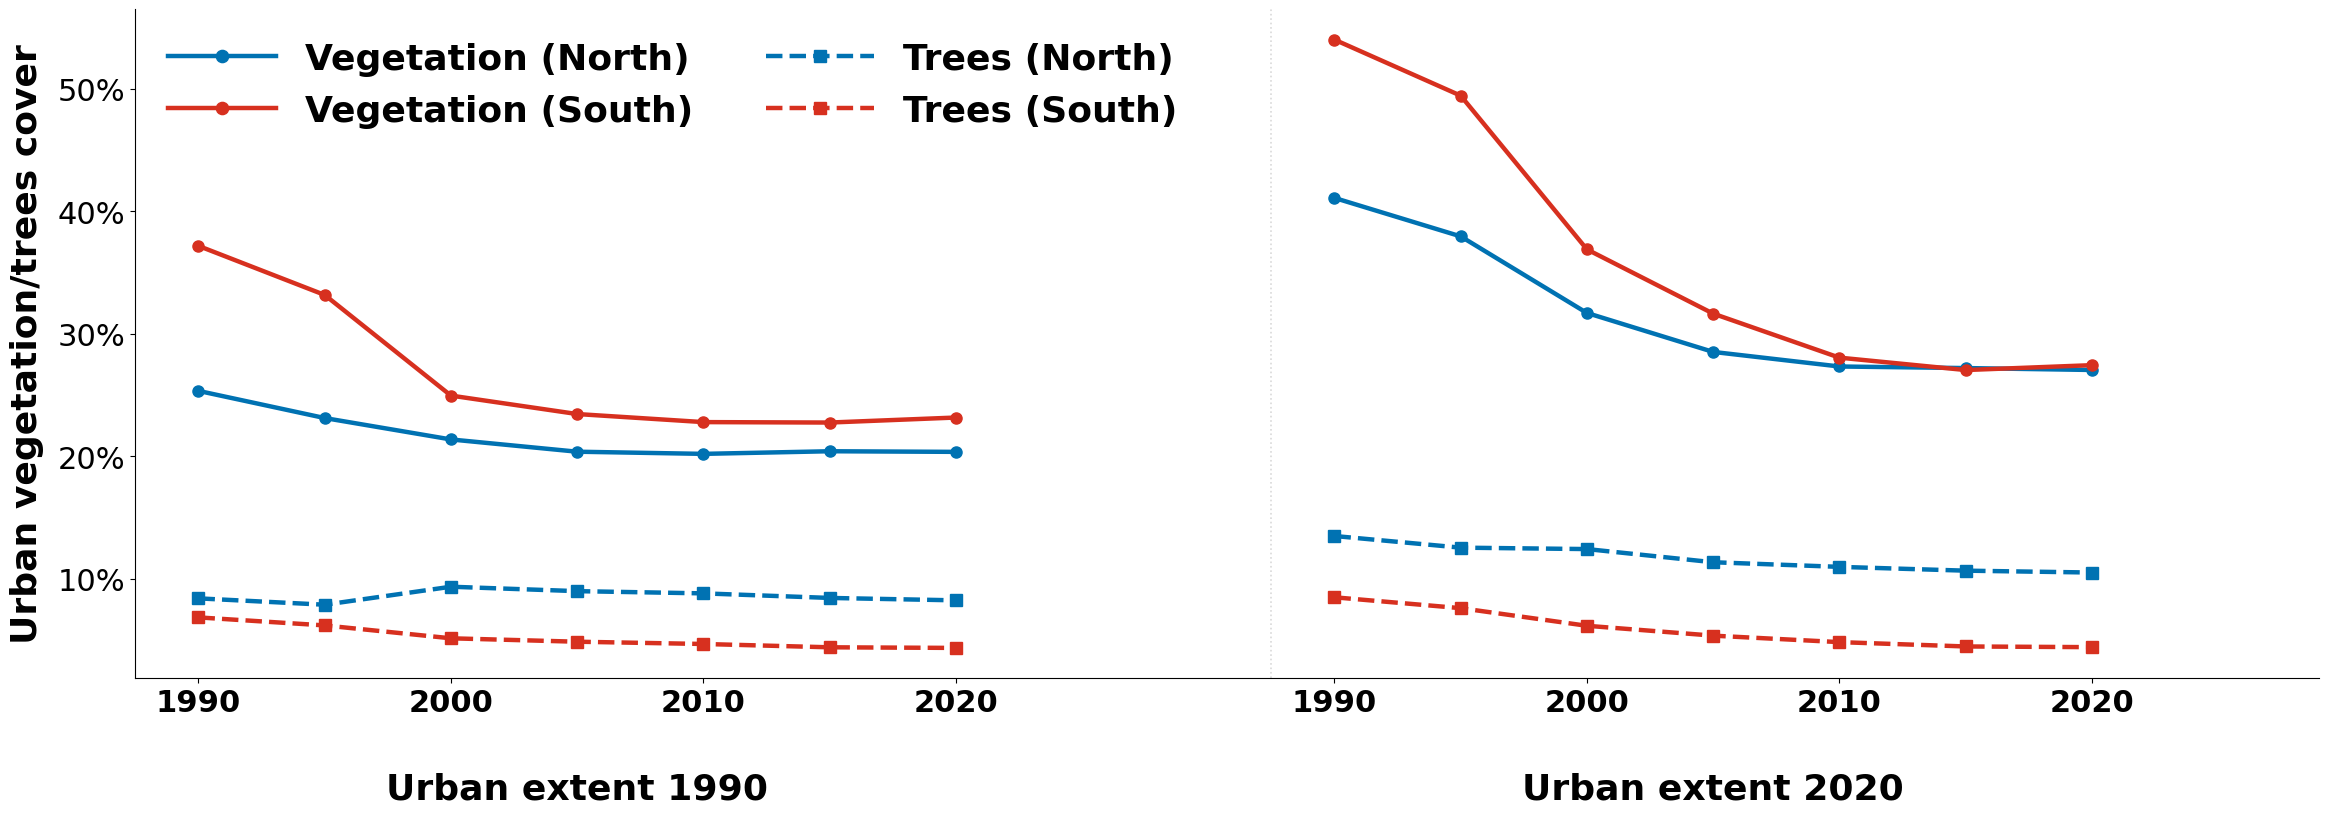

In [29]:
from __future__ import annotations
import os, warnings
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.transforms import blended_transform_factory as btf

# --------------------------- Large fonts (and NO GRID) -----------------------
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 26,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 26,   # ↑ increased default legend size
    "axes.grid": False,      # ensure no grids globally
})

# Colors (Okabe–Ito)
C_NORTH = "#0072B2"   # blue
C_SOUTH = "#d7301f"   # vermillion

# Label placement controls
X_PAD_INSIDE        = 0.60
LABEL_Y_BUMP_FRAC   = 0.020
DEOVERLAP_Y_FRAC    = 0.06
EXTRA_RIGHT_SPACE   = 1.80

# Global North by ISO3 (YOUR set)
GLOBAL_NORTH_ISO3 = {
    "ARE","AUS","AUT","BEL","BHS","BRN","CAN","CHE","CYP","CZE","DEU","DNK","ESP","EST",
    "FIN","FRA","GBR","GNQ","GRC","HRV","HUN","IRL","ISL","ISR","ITA","JPN","KOR","KWT",
    "LUX","NCL","NLD","NOR","NZL","OMN","POL","PRI","PRT","QAT","SAU","SVK","SVN","SWE",
    "TTO","TWN","USA"
}

FILENAMES = dict(
    veg_1992  = "vegUrban_1990_2020_constBuiltUp1992_100m.csv",
    veg_2020  = "vegUrban_1990_2020_constBuiltUp2020_100m.csv",
    tree_1992 = "treeUrban_1990_2020_constBuiltUp1992_100m.csv",
    tree_2020 = "treeUrban_1990_2020_constBuiltUp2020_100m.csv",
)

# ----------------------------- I/O helpers -----------------------------------
def _base_dir() -> str:
    return next((b for b in ("/content", "/mnt/data", ".") if os.path.exists(b)), ".")

def _first_existing(*cands: str) -> str:
    for p in cands:
        if p and os.path.exists(p):
            return p
    raise FileNotFoundError(f"No candidate path exists among: {cands!r}")

def _detect_builtup(cols: List[str]) -> str:
    opts = [c for c in cols if c.startswith("builtUp_m2_")]
    if not opts:
        raise ValueError("No 'builtUp_m2_<year>' column found.")
    if len(opts) > 1:
        opts.sort()
        warnings.warn(f"Multiple built-up columns {opts}; using {opts[-1]}")
    return opts[-1]

def _parse_year(col: str) -> int | None:
    try:
        y = int(col.rsplit("_", 1)[-1])
        return y if 1900 <= y <= 2100 else None
    except Exception:
        return None

def _load_tag(csv_path: str, prefix: str):
    head = pd.read_csv(csv_path, nrows=0)
    cols = list(head.columns)
    if "shapeISO_1990" not in cols:
        raise KeyError(f"'shapeISO_1990' missing in {csv_path}")
    built = _detect_builtup(cols)
    ycols = [(y, c) for c in cols if c.startswith(prefix) and (y := _parse_year(c))]
    ycols.sort(key=lambda t: t[0])
    if not ycols:
        raise ValueError(f"No '{prefix}YYYY' columns in {csv_path}")

    use = ["shapeISO_1990", built] + [c for _, c in ycols]
    try:
        df = pd.read_csv(csv_path, usecols=use)
    except ValueError:
        df = pd.read_csv(csv_path)

    df[built] = pd.to_numeric(df[built], errors="coerce")
    df.loc[~np.isfinite(df[built]) | (df[built] <= 0), built] = np.nan
    for _, c in ycols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df.loc[~np.isfinite(df[c]) | (df[c] < 0), c] = np.nan

    iso = df["shapeISO_1990"].astype(str).str.upper().str.strip()
    df["group"] = np.where(iso.isin(GLOBAL_NORTH_ISO3), "North", "South")
    return df, built, ycols

def _fractions_by_group(df: pd.DataFrame, built: str, ycols):
    rows = []
    for grp, sub in df.groupby("group", dropna=False):
        denom = sub[built].sum(min_count=1)
        for y, c in ycols:
            num = sub[c].sum(min_count=1)
            val = (
                np.nan
                if (not np.isfinite(denom) or denom <= 0 or not np.isfinite(num))
                else float(num / denom)
            )
            rows.append({"year": y, "group": grp, "fraction": val})
    return pd.DataFrame(rows)

def _compute_all(base_dir: str) -> pd.DataFrame:
    tasks = [
        ("veg","1992", os.path.join(base_dir, FILENAMES["veg_1992"]),  "veg_in_urban_m2_"),
        ("veg","2020", os.path.join(base_dir, FILENAMES["veg_2020"]),  "veg_in_urban_m2_"),
        ("tree","1992",os.path.join(base_dir, FILENAMES["tree_1992"]), "tree_in_urban_m2_"),
        ("tree","2020",os.path.join(base_dir, FILENAMES["tree_2020"]), "tree_in_urban_m2_"),
    ]
    out = []
    for metric, extent, path, prefix in tasks:
        path = _first_existing(path)
        df, built, ycols = _load_tag(path, prefix)
        tmp = _fractions_by_group(df, built, ycols)
        tmp["metric"] = metric
        tmp["extent"] = extent
        out.append(tmp)
    tidy = pd.concat(out, ignore_index=True)

    # Align to common years across all series
    by_key = tidy.groupby(["metric","extent","group"])
    sets = [set(g["year"]) for _, g in by_key]
    common = sorted(set.intersection(*sets)) if sets else []
    if common:
        tidy = tidy[tidy["year"].isin(common)].copy()
    return tidy

# ----------------------------- Series helpers --------------------------------
def _to_pct(a: List[float]) -> List[float]:
    return [np.nan if (v is None or not np.isfinite(v)) else 100.0 * v for v in a]

def _series(df: pd.DataFrame, metric: str, extent: str, group: str, years: List[int]) -> List[float]:
    s = df[(df.metric==metric)&(df.extent==extent)&(df.group==group)].set_index("year")["fraction"]
    return _to_pct([s.get(y, np.nan) for y in years])

def _first_last_valid(arr: List[float]) -> Tuple[float|None, float|None]:
    a0 = next((v for v in arr if v is not None and np.isfinite(v)), None)
    a1 = next((arr[i] for i in range(len(arr)-1, -1, -1)
               if arr[i] is not None and np.isfinite(arr[i])), None)
    return (None if a0 is None else float(a0),
            None if a1 is None else float(a1))

def _end_delta_pp_only(arr: List[float]) -> Tuple[float|None, float|None]:
    a0, a1 = _first_last_valid(arr)
    if a1 is None:
        return None, None
    dpp = None if (a0 is None) else (a1 - a0)
    return a1, dpp

def _fmt_label(prefix: str, arr: List[float]) -> str:
    a1, dpp = _end_delta_pp_only(arr)
    vtxt = f"{a1:.1f}%" if a1 is not None else "NA"
    part_pp = f"{dpp:+.1f} pp" if dpp is not None else None
    if part_pp:
        return f"{prefix} {vtxt} ({part_pp})"
    else:
        return f"{prefix} {vtxt}"

def _final(arr: List[float]) -> float | None:
    a1 = next((arr[i] for i in range(len(arr)-1, -1, -1)
               if arr[i] is not None and np.isfinite(arr[i])), None)
    return None if a1 is None else float(a1)

# ----------------------------- Plot helpers ----------------------------------
def _annotate_inside(ax, x_pos: float, lines: List[Tuple[str,float,str]]):
    rlo, rhi = ax.get_ylim()
    dy_min  = (rhi - rlo) * DEOVERLAP_Y_FRAC
    dy_bump = (rhi - rlo) * LABEL_Y_BUMP_FRAC

    items = [d for d in lines if d[1] is not None and np.isfinite(d[1])]
    items.sort(key=lambda t: t[1], reverse=True)
    last = float("inf")
    for txt, y, col in items:
        if last - y < dy_min:
            y = last - dy_min
        y += dy_bump
        y = max(rlo + 0.5, min(rhi - 0.5, y))
        last = y
        ax.text(x_pos, y, txt, color=col, fontsize=18, fontweight="bold",
                ha="left", va="center", clip_on=False)

def plot_two_halves(tidy: pd.DataFrame, out_path: str):
    years = sorted(tidy["year"].unique())
    n = len(years)
    gap = 2

    # x coords
    x_left  = np.arange(n)
    x_right = np.arange(n) + (n + gap)

    # ticks: only 1990/2000/2010/2020 on BOTH halves
    wanted = {1990, 2000, 2010, 2020}
    idx_left  = [i for i, y in enumerate(years) if y in wanted]
    idx_right = [i for i, y in enumerate(years) if y in wanted]
    xticks = [x_left[i] for i in idx_left] + [x_right[i] for i in idx_right]
    xticklabels = [str(years[i]) for i in idx_left] + [str(years[i]) for i in idx_right]

    fig, ax = plt.subplots(figsize=(25, 8.5))

    # thin separator between halves (not a gridline)
    ax.axvline(n + gap - 0.5, color="0.85", linestyle=":", linewidth=1.2)

    # series
    vN_92 = _series(tidy, "veg",  "1992", "North", years)
    vS_92 = _series(tidy, "veg",  "1992", "South", years)
    tN_92 = _series(tidy, "tree", "1992", "North", years)
    tS_92 = _series(tidy, "tree", "1992", "South", years)

    vN_20 = _series(tidy, "veg",  "2020", "North", years)
    vS_20 = _series(tidy, "veg",  "2020", "South", years)
    tN_20 = _series(tidy, "tree", "2020", "North", years)
    tS_20 = _series(tidy, "tree", "2020", "South", years)

    lw, ms = 3.2, 8.0
    # LEFT (built 1990)
    ax.plot(x_left, vN_92, marker="o", linestyle="-",  color=C_NORTH, linewidth=lw, markersize=ms, label="Vegetation (North)")
    ax.plot(x_left, vS_92, marker="o", linestyle="-",  color=C_SOUTH, linewidth=lw, markersize=ms, label="Vegetation (South)")
    ax.plot(x_left, tN_92, marker="s", linestyle="--", color=C_NORTH, linewidth=lw, markersize=ms, label="Trees (North)")
    ax.plot(x_left, tS_92, marker="s", linestyle="--", color=C_SOUTH, linewidth=lw, markersize=ms, label="Trees (South)")

    # RIGHT (built 2020)
    ax.plot(x_right, vN_20, marker="o", linestyle="-",  color=C_NORTH, linewidth=lw, markersize=ms)
    ax.plot(x_right, vS_20, marker="o", linestyle="-",  color=C_SOUTH, linewidth=lw, markersize=ms)
    ax.plot(x_right, tN_20, marker="s", linestyle="--", color=C_NORTH, linewidth=lw, markersize=ms)
    ax.plot(x_right, tS_20, marker="s", linestyle="--", color=C_SOUTH, linewidth=lw, markersize=ms)

    # --- ensure extra space for right labels ---
    ax.set_xlim(-0.5, x_right[-1] + EXTRA_RIGHT_SPACE)

    # axes cosmetics
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontweight="bold")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    ax.set_ylabel("Urban vegetation/trees cover", fontweight="bold", labelpad=10)

    # NO grids of any kind
    ax.grid(False)
    ax.minorticks_off()
    for s in ("top","right"):
        ax.spines[s].set_visible(False)

    # ——— Bigger, bolder legend (2 columns) ———
    ax.legend(
        frameon=False,
        ncol=2,
        loc="upper left",
        fontsize=22,                 # ↑ explicitly large
        prop={'weight': 'bold'},     # bold labels
        handlelength=3,
        markerscale=1.1
    )

    # (Optional) inside Δpp labels are currently commented out above

    # under-axis panel labels
    tx = btf(ax.transData, ax.transAxes)
    ax.text((x_left[0]+x_left[-1]) / 2, -0.14, "Urban extent 1990",
            transform=tx, ha="center", va="top", fontsize=26, fontweight="bold")
    ax.text((x_right[0]+x_right[-1]) / 2, -0.14, "Urban extent 2020",
            transform=tx, ha="center", va="top", fontsize=26, fontweight="bold")

    # layout and save
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout(rect=[0, 0, 0.95, 1])  # reserve 5% on the right

    out_dir = os.path.dirname(out_path) or "."
    os.makedirs(out_dir, exist_ok=True)

    plt.savefig(out_path, bbox_inches='tight', format='pdf', transparent=True)
    print(f"Figure saved → {out_path}")
    plt.show()

# --------------------------------- main --------------------------------------
def main():
    try:
        base = _base_dir()
        tidy = _compute_all(base)
        if tidy.empty:
            raise RuntimeError("No data to plot after loading and alignment.")
        out_path = "/content/Fig5B.pdf"
        plot_two_halves(tidy, out_path)
    except Exception as e:
        raise SystemExit(f"[FATAL] {type(e).__name__}: {e}")

if __name__ == "__main__":
    main()
